### Objective Function

Given:
- $ \mathbf{x}' \sim p_{dist}(\mathbf{x}', \mathbf{x}) = \frac{1}{\lambda \|\mathbf{x} - \mathbf{x}'\|_2^2} $: Target variable (Counterfactual Explanation).
- $ \mathbf{x} \in \mathbb{R}^d $: Conditional variable (Data Point).
- $ p_\theta(\mathbf{x}' | \mathbf{x}) $: Conditional density modeled by the flow.

The optimization objective:
$$
\mathcal{L}(\theta) = - \log p_\theta(f_\theta(\mathbf{x}, \mathbf{x}')) - \log \left| \det \frac{\partial f_\theta(\mathbf{x}, \mathbf{x}')}{\partial \mathbf{x}} \right|
$$

### Optimization Problem

$$
\theta^* = \arg\min_\theta \mathcal{L}(\theta).
$$

### Components
1. **Conditional Log-Likelihood**:
   $$
   -\log p_\theta(\mathbf{x} | \mathbf{x}').
   $$
2. **Regularization**: 
   $$
   \lambda \|\mathbf{x} - \mathbf{x}'\|_2^2.
   $$
3. **Trade-off**: Controlled by $ \lambda $.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

from matplotlib import cm
from torch.utils.data import DataLoader, Dataset


from counterfactuals.datasets import MoonsDataset
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.discriminative_models import (
    MultilayerPerceptron,
)
from counterfactuals.metrics import CFMetrics

from counterfactuals.plot_utils import (
    plot_generative_model_distribution,
    plot_classifier_decision_region,
)

In [3]:
dataset = MoonsDataset(file_path="../../data/moons.csv")
# dataset = LawDataset(file_path="../../data/law.csv")

In [4]:
flow_train_dataloader = dataset.train_dataloader(
    batch_size=128, shuffle=True, noise_lvl=0.03
)
flow_test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)
flow = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.fit(flow_train_dataloader, flow_test_dataloader, num_epochs=1000, patience=50)

Epoch 264, Train: -1.2757, test: -1.4805, patience: 50:  26%|██▋       | 264/1000 [00:23<01:05, 11.21it/s]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open a

In [5]:
# dataset = MoonsDataset(file_path="../../data/moons.csv")
# # dataset = LawDataset(file_path="../../data/law.csv")
# disc_model = LogisticRegression(input_size=2, target_size=1)
# train_dataloader = dataset.train_dataloader(batch_size=256, shuffle=True, noise_lvl=0.0)
# test_dataloader = dataset.test_dataloader(batch_size=256, shuffle=False)
# disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=300, lr=1e-3)

In [6]:
dataset = MoonsDataset(file_path="../../data/moons.csv")
# dataset = LawDataset(file_path="../../data/law.csv")
disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=0.0)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
disc_model.fit(train_dataloader, test_dataloader, epochs=10000, patience=100, lr=1e-3)
# validate
y_pred = disc_model.predict(dataset.X_test).detach().numpy()
y_true = dataset.y_test
print(f"Accuracy: {np.mean(y_pred == y_true)}")
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

disc_model.eval()
dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

Epoch 363, Train: 0.0014, test: 0.0118, patience: 100:   4%|▎         | 364/10000 [00:06<02:57, 54.42it/s]

Accuracy: 0.9951219512195122



/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/discriminative_models/multilayer_perceptron.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_s

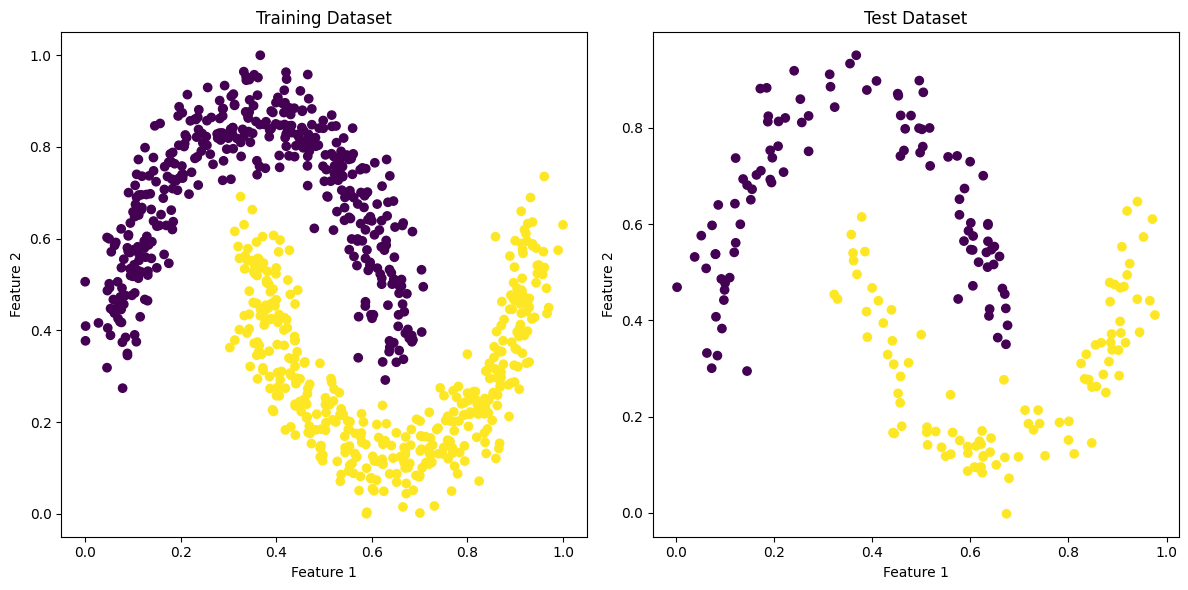

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training dataset
axes[0].scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='viridis', marker='o')
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Plot test dataset
axes[1].scatter(dataset.X_test[:, 0], dataset.X_test[:, 1], c=dataset.y_test, cmap='viridis', marker='o')
axes[1].set_title('Test Dataset')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# PairDistanceDataset

In [8]:
class PairDistanceDataset(Dataset):
    def __init__(self, class_zero, class_one, length=None):
        """
        Initialize with two arrays, one for each class.
        """
        self.length = length
        self.class_zero = torch.tensor(class_zero, dtype=torch.float32)
        self.class_one = torch.tensor(class_one, dtype=torch.float32)

        # Calculate pairwise distances between zero and one classes
        self.zero_one_distance = torch.cdist(self.class_zero, self.class_one)

        self.size_zero = class_zero.shape[0]
        self.size_one = class_one.shape[0]

    def __len__(self):
        # The total combinations are len(class_zero) * len(class_one)
        if self.length is not None:
            return self.length
        return self.size_zero * self.size_one

    def get_specific_item(self, idx):
        """
        Get the specific item based on the index.
        Sample the second point based on the distance weight from another class.
        """
        if idx < self.size_zero:
            i = idx
            x_orig = self.class_zero[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[i] ** 2
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_one[j]
        else:
            i = idx - self.size_zero
            x_orig = self.class_one[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[:, i] ** 2
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

    def __getitem__(self, idx):
        """
        Randomly select a point from one class.
        Sample the second point based on the distance weight from another class.
        """
        if torch.rand(1) > 0.5:
            i = torch.randint(0, self.size_zero, (1,)).item()
            x_orig = self.class_zero[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[i] ** 2
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_one[j]
        else:
            i = torch.randint(0, self.size_one, (1,)).item()
            x_orig = self.class_one[i]

            # Calculate weights for sampling y
            zero_one_weight = 1 / self.zero_one_distance[:, i] ** 2
            zero_one_weight /= zero_one_weight.sum()

            j = torch.multinomial(zero_one_weight, num_samples=1).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

In [9]:
class ClosestPairDataset(PairDistanceDataset):
    def get_specific_item(self, idx):
        """
        Get the specific item based on the index.
        Sample the second point based on the distance weight from another class.
        """
        if idx < self.size_zero:
            i = idx
            x_orig = self.class_zero[i]

            # Find the closest point in class_one
            j = torch.argmin(self.zero_one_distance[i]).item()
            x_cf = self.class_one[j]
        else:
            i = idx - self.size_zero
            x_orig = self.class_one[i]

            # Find the closest point in class_zero
            j = torch.argmin(self.zero_one_distance[:, i]).item()
            x_cf = self.class_zero[j]
        return torch.tensor(x_cf, dtype=torch.float32), torch.tensor(
            x_orig, dtype=torch.float32
        )

    def __getitem__(self, idx):
        """
        Randomly select a point from one class.
        Select the closest point from the opposite class.
        """
        probe_class = random.choice([0, 1])

        if probe_class == 0:
            probe_dataset = self.class_zero
            compare_dataset = self.class_one
            probe_index = random.randint(0, len(probe_dataset) - 1)
            probe = probe_dataset[probe_index]

            # Find the closest point in class_one
            _, compare_indices = torch.topk(-self.zero_one_distance[probe_index], k=1)
            comparisons = compare_dataset[compare_indices]
        else:
            probe_dataset = self.class_one
            compare_dataset = self.class_zero
            probe_index = random.randint(0, len(probe_dataset) - 1)
            probe = probe_dataset[probe_index]

            # Find the closest point in class_one
            _, compare_indices = torch.topk(
                -self.zero_one_distance[:, probe_index], k=1
            )
            comparisons = compare_dataset[compare_indices]

        pairs = [(cmp, probe) for cmp in comparisons]
        return pairs

In [10]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = ClosestPairDataset(class_zero, class_one, length=1000)

In [36]:
class_one = dataset.X_test[dataset.y_test == 1]
class_one = class_one[(class_one[:, 0] < 0.45) & (class_one[:, 0] > 0.3)]

In [37]:
class_one

array([[0.3904493 , 0.36518872],
       [0.43195155, 0.32879874],
       [0.3694302 , 0.49543357],
       [0.44513762, 0.16510318],
       [0.36240086, 0.5239308 ],
       [0.36135322, 0.5398172 ],
       [0.38557813, 0.542712  ],
       [0.42295572, 0.3944445 ],
       [0.44409227, 0.30889827],
       [0.4427154 , 0.16685757],
       [0.32298324, 0.4537832 ],
       [0.35775244, 0.57822245],
       [0.43969807, 0.42179424],
       [0.3887951 , 0.41806477],
       [0.41298208, 0.44065696],
       [0.4003428 , 0.46739015],
       [0.44137955, 0.35750982],
       [0.37896135, 0.6147141 ],
       [0.3297888 , 0.44430396]], dtype=float32)

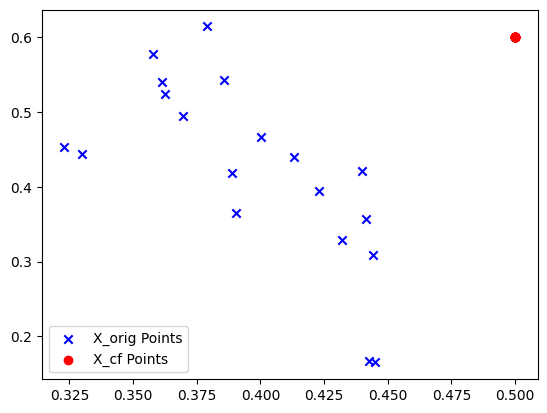

In [ ]:
import numpy as np

x_orig = np.array([[0.3904493 , 0.36518872],
[0.43195155, 0.32879874],
[0.3694302 , 0.49543357],
[0.44513762, 0.16510318],
[0.36240086, 0.5239308 ],
[0.36135322, 0.5398172 ],
[0.38557813, 0.542712  ],
[0.42295572, 0.3944445 ],
[0.44409227, 0.30889827],
[0.4427154 , 0.16685757],
[0.32298324, 0.4537832 ],
[0.35775244, 0.57822245],
[0.43969807, 0.42179424],
[0.3887951 , 0.41806477],
[0.41298208, 0.44065696],
[0.4003428 , 0.46739015],
[0.44137955, 0.35750982],
[0.37896135, 0.6147141 ],
[0.3297888 , 0.44430396]])

x_cf = np.array([0.5, 0.6])
x_cf = np.tile(x_cf, (x_orig.shape[0], 1))

plt.scatter(x_orig[:, 0], x_orig[:, 1], c='blue', marker='x', label='X_orig Points')
plt.scatter(x_cf[:, 0], x_cf[:, 1], c='red', marker='o', label='X_cf Points')
plt.legend()
plt.show()

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Create a TensorDataset with x_origs and x_cfs
x_orig = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
x_cf = np.array([[2, 3], [4, 5], [6, 7], [8, 9]])
x_orig = torch.Tensor(x_orig)
x_cf = torch.Tensor(x_cf)
pair_dataset = TensorDataset(x_cf, x_orig)

# Define the split ratio
train_size = int(0.8 * len(pair_dataset))
test_size = len(pair_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(pair_dataset, [train_size, test_size])

# Create DataLoaders for the train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Example of iterating through the train dataloader
for x_cf_batch, x_orig_batch in train_dataloader:
    print(f"Train - x_orig_batch: {x_orig_batch}")
    print(f"Train - x_cf_batch: {x_cf_batch}")
    break

# Example of iterating through the test dataloader
for x_cf_batch, x_orig_batch in test_dataloader:
    print(f"Test - x_orig_batch: {x_orig_batch}")
    print(f"Test - x_cf_batch: {x_cf_batch}")
    break

Train - x_orig_batch: tensor([[0.4427, 0.1669],
        [0.4441, 0.3089]])
Train - x_cf_batch: tensor([[0.5000, 0.6000],
        [0.5000, 0.6000]])
Test - x_orig_batch: tensor([[0.3904, 0.3652],
        [0.4451, 0.1651]])
Test - x_cf_batch: tensor([[0.5000, 0.6000],
        [0.5000, 0.6000]])


In [46]:
cf = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=2,
    context_features=dataset.X_test.shape[1],
)
cf.fit(
    pair_dataloader, pair_dataloader, num_epochs=1000, learning_rate=1e-4, patience=20, checkpoint_path="best_cf_model.pt"
)
# cf.load("best_cf_model.pt")

Epoch 846, Train: -15.3586, test: -15.3688, patience: 20:  85%|████████▍ | 846/1000 [00:19<00:03, 44.29it/s]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open

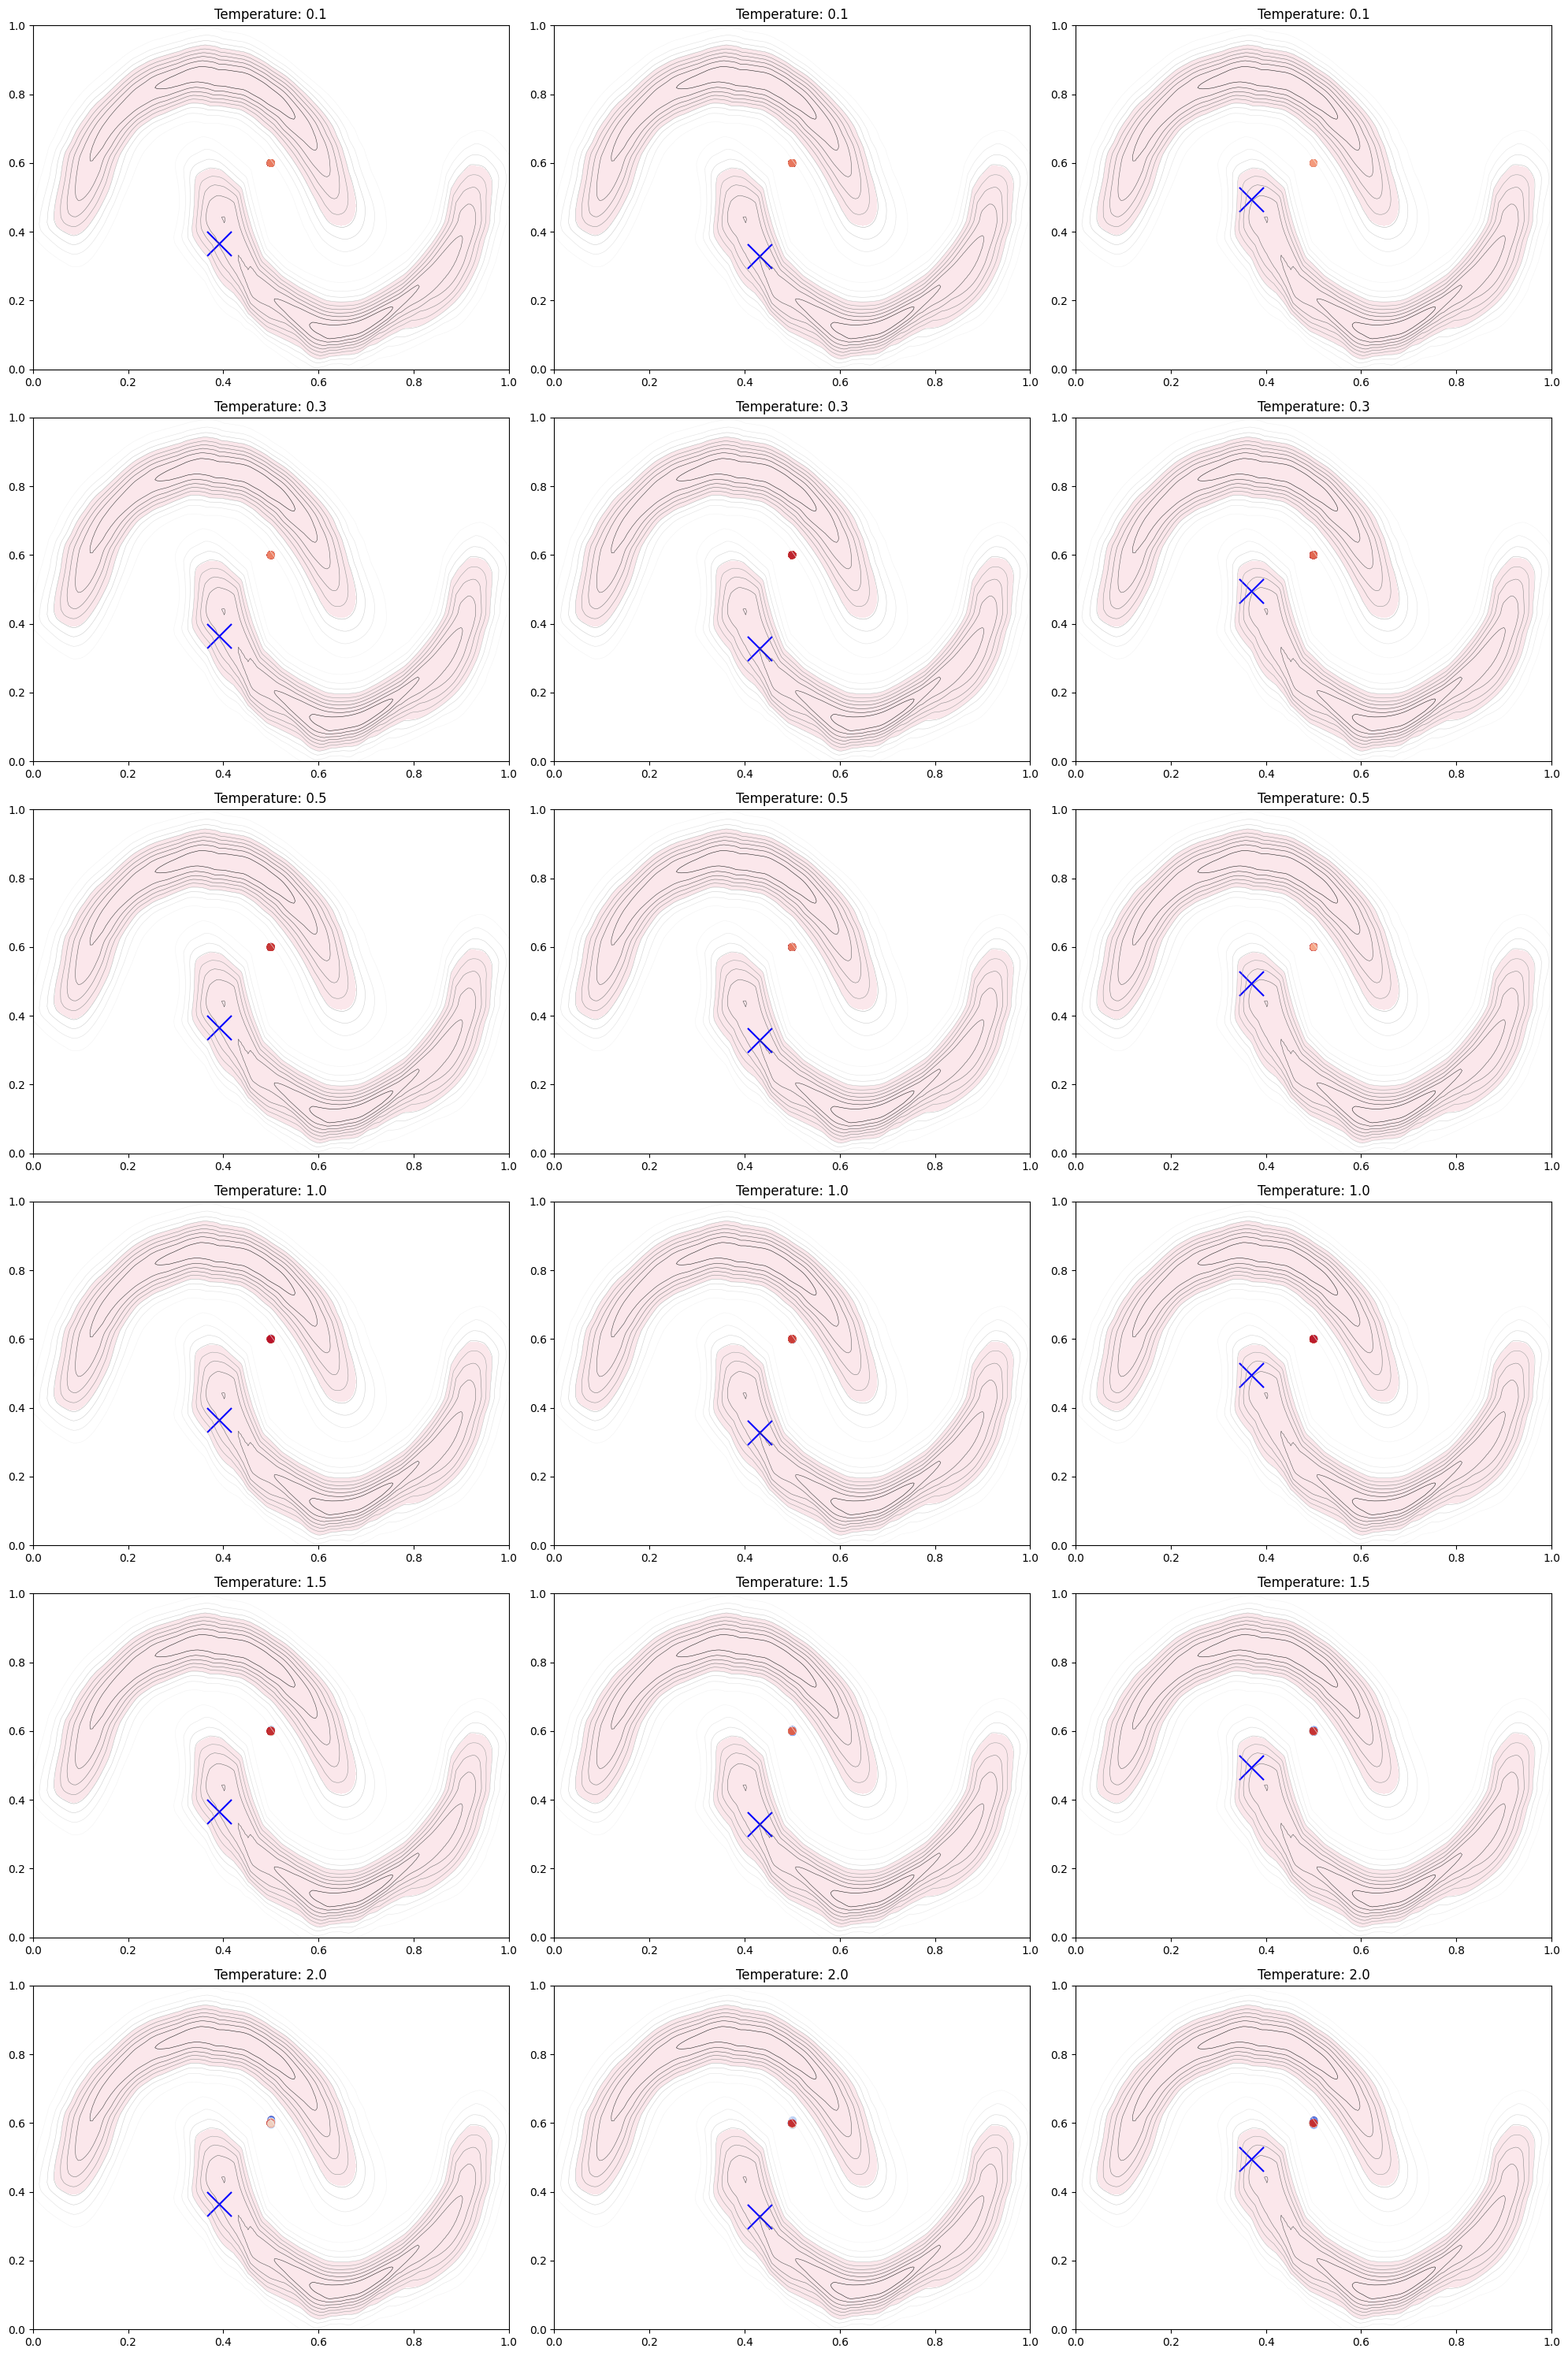

In [48]:
fig, ax = plt.subplots(6, 3, figsize=(20, 30))

for t_i, t in enumerate([0.1, 0.3, 0.5, 1.0, 1.5, 2.0]):
    for i_i, i in enumerate(range(3)):
        with torch.no_grad():
            points, log_prob = cf.sample_and_log_prob(
                1000, context=torch.from_numpy(np.array([x_orig[i]])), temp=t
            )

        points = points.squeeze().numpy()
        plot_generative_model_distribution(ax[t_i, i_i], flow, 1.2, torch.Tensor([0]))
        plot_generative_model_distribution(ax[t_i, i_i], flow, 1.2, torch.Tensor([1]))
        ax[t_i, i_i].scatter(
            x_orig[i, 0],
            x_orig[i, 1],
            c="blue",
            s=500,
            marker="x",
            label="Original",
        )
        ax[t_i, i_i].scatter(
            points[:, 0],
            points[:, 1],
            c=log_prob,
            cmap=cm.coolwarm,
            label="Counterfactuals",
        )
        ax[t_i, i_i].set_title(f"Temperature: {t}")

plt.tight_layout()
plt.show()

/Users/oleksiifurman/Developer/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


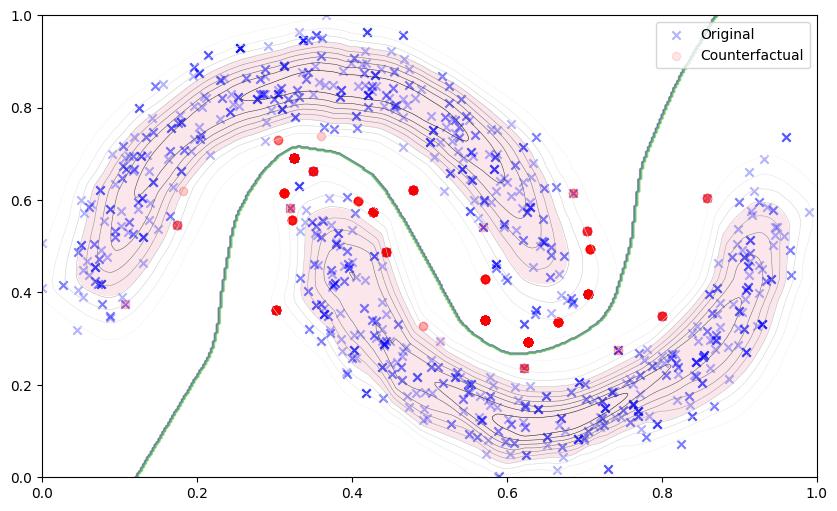

In [11]:
x_cfs, x_origs = [], []
for i in range(1000):
    # x_cf, x_orig = pair_dataset_train.get_specific_item(class_zero.shape[0] + 253)
    x_cf, x_orig = pair_dataset_train[5][0]
    x_cfs.append(x_cf)
    x_origs.append(x_orig)
x_cfs = torch.vstack(x_cfs)
x_origs = torch.vstack(x_origs)

# plt.figure(figsize=(6, 6))

fig, ax = plt.subplots(figsize=(10, 6))

plot_generative_model_distribution(ax, flow, 1.2, torch.Tensor([1.0]))
plot_generative_model_distribution(ax, flow, 1.2, torch.Tensor([0.0]))
plot_classifier_decision_region(ax, disc_model)


ax.scatter(x_origs[:, 0], x_origs[:, 1], c='blue', marker='x', label='Original', alpha=0.3)
ax.scatter(x_cfs[:, 0], x_cfs[:, 1], c='red', marker='o', label='Counterfactual', alpha=0.1)
plt.legend()

In [12]:
class_zero = dataset.X_train[dataset.y_train == 0]
class_one = dataset.X_train[dataset.y_train == 1]

pair_dataset_train = ClosestPairDataset(class_zero, class_one, length=1000)


def collate_fn(batch):
    """
    Custom collate function to handle batched pairwise data.
    It flattens the batch from List[List[Tuple]] to List[Tuple]
    """
    flattened_batch = [pair for sublist in batch for pair in sublist]
    comparisons, probes = zip(*flattened_batch)
    comparisons, probes = torch.stack(comparisons), torch.stack(probes)
    noise = torch.randn_like(probes) * 0.0003
    probes = probes + noise

    noise = torch.randn_like(comparisons) * 0.0003
    comparisons = comparisons + noise
    return comparisons, probes


BATCH_SIZE = 1

train_dataloader = DataLoader(
    pair_dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

class_zero = dataset.X_test[dataset.y_test == 0]
class_one = dataset.X_test[dataset.y_test == 1]

pair_dataset_test = ClosestPairDataset(class_zero, class_one)

test_dataloader = DataLoader(
    pair_dataset_test, batch_size=256, shuffle=False, collate_fn=collate_fn
)

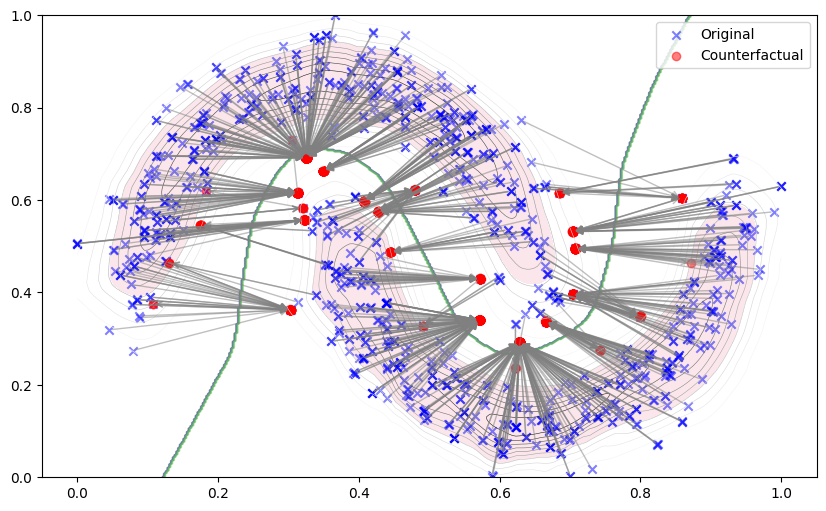

In [14]:
xs, ys = [], []
for i, (x_cfs, x_origs) in enumerate(train_dataloader):
    xs.append(x_cfs)
    ys.append(x_origs)

x_cfs = torch.cat(xs)
x_origs = torch.cat(ys)
# for i, (x_cfs, x_origs) in enumerate(train_dataloader):
#     if i == 5:
#         break

fig, ax = plt.subplots(figsize=(10, 6))

plot_generative_model_distribution(ax, flow, 1.2, torch.Tensor([1.0]))
plot_generative_model_distribution(ax, flow, 1.2, torch.Tensor([0.0]))
plot_classifier_decision_region(ax, disc_model)

ax.scatter(
    x_origs[:, 0], x_origs[:, 1], c="blue", marker="x", label="Original", alpha=0.5
)
ax.scatter(
    x_cfs[:, 0], x_cfs[:, 1], c="red", marker="o", label="Counterfactual", alpha=0.5
)

# Add arrows
for orig, cf in zip(x_origs, x_cfs):
    ax.annotate(
        "",
        xy=(cf[0], cf[1]),
        xytext=(orig[0], orig[1]),
        arrowprops=dict(arrowstyle="->", color="gray", alpha=0.5),
    )

plt.legend()
plt.show()

In [160]:
cf = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=16,
    num_blocks_per_layer=2,
    num_layers=2,
    context_features=dataset.X_test.shape[1],
)
cf.fit(
    train_dataloader,
    test_dataloader,
    num_epochs=1000,
    learning_rate=1e-4,
    patience=20,
    checkpoint_path="best_cf_model.pt",
)
# cf.load("best_cf_model.pt")

Epoch 33, Train: -2.9059, test: -2.0390, patience: 20:   3%|▎         | 33/1000 [01:04<31:30,  1.96s/it]
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/generative_models/maf.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an 

IndexError: index 54 is out of bounds for axis 0 with size 19

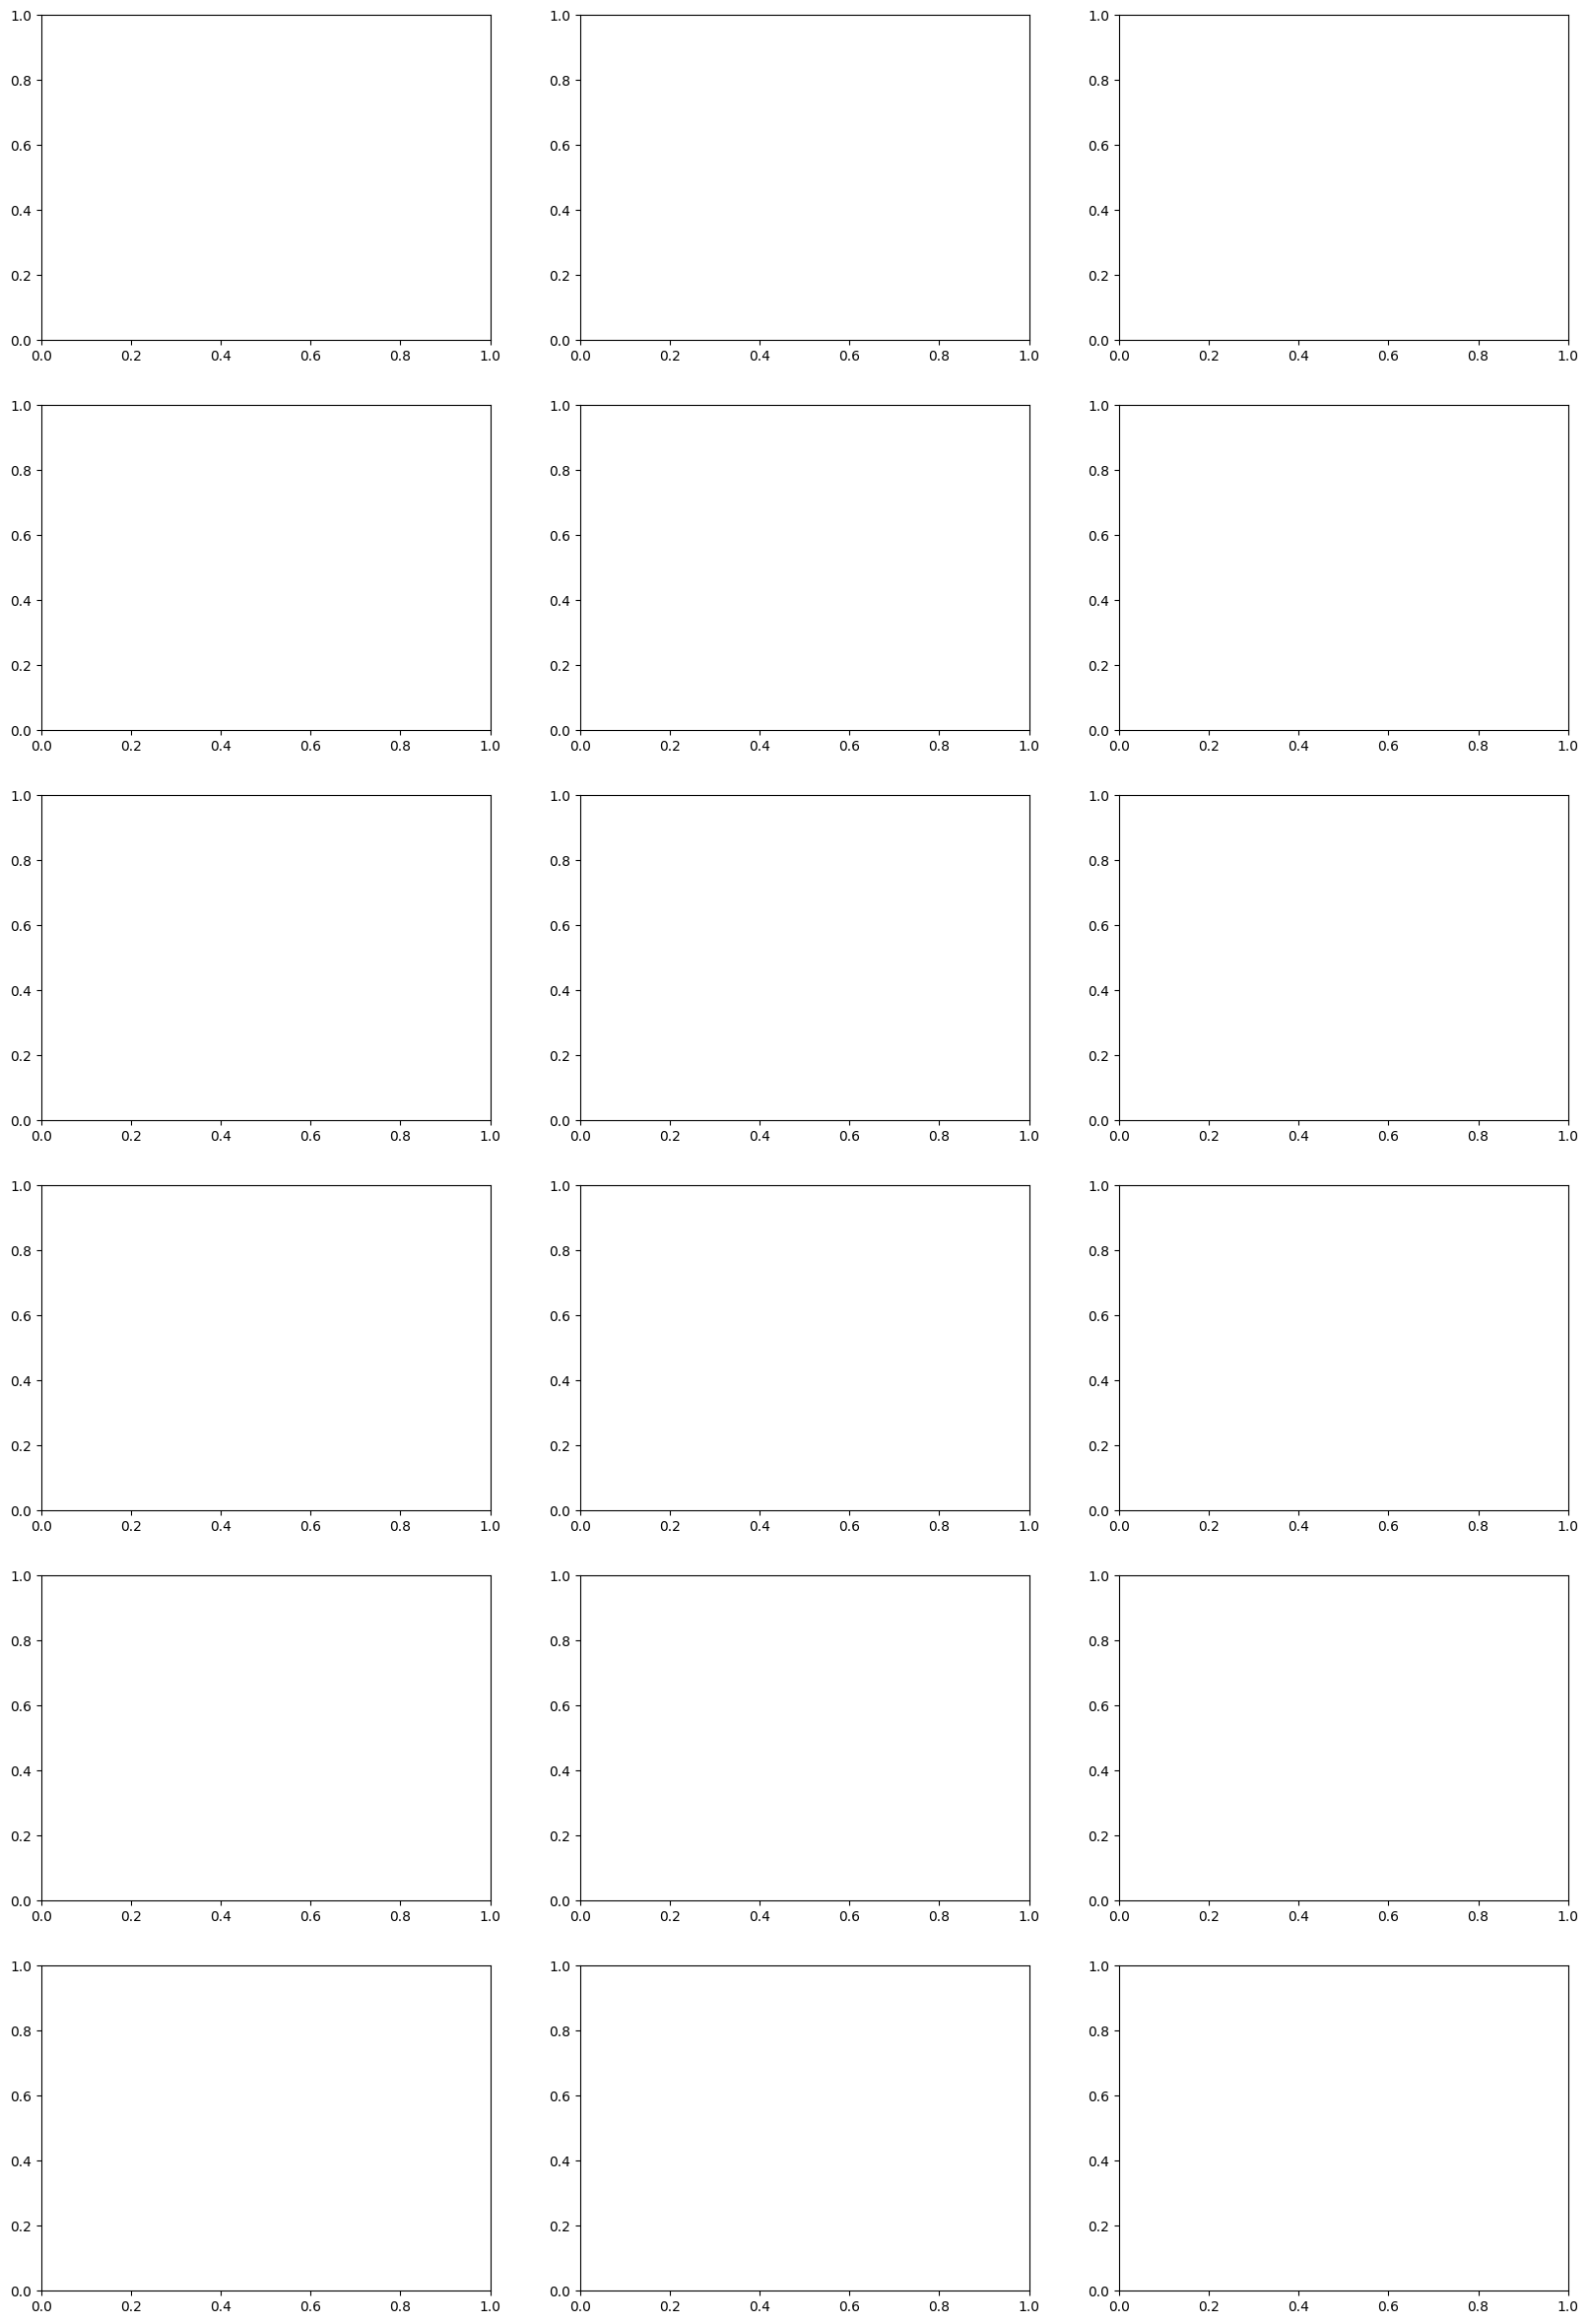

In [47]:
fig, ax = plt.subplots(6, 3, figsize=(20, 30))

for t_i, t in enumerate([0.1, 0.3, 0.5, 1.0, 1.5, 2.0]):
    for i_i, i in enumerate(range(54, 57)):
        with torch.no_grad():
            points, log_prob = cf.sample_and_log_prob(
                1000, context=torch.from_numpy(np.array([class_one[i]])), temp=t
            )

        points = points.squeeze().numpy()
        plot_generative_model_distribution(ax[t_i, i_i], flow, 1.2, torch.Tensor([0]))
        plot_generative_model_distribution(ax[t_i, i_i], flow, 1.2, torch.Tensor([1]))
        ax[t_i, i_i].scatter(
            class_one[i, 0],
            class_one[i, 1],
            c="blue",
            s=500,
            marker="x",
            label="Original",
        )
        ax[t_i, i_i].scatter(
            points[:, 0],
            points[:, 1],
            c=log_prob,
            cmap=cm.coolwarm,
            label="Counterfactuals",
        )
        ax[t_i, i_i].set_title(f"Temperature: {t}")

plt.tight_layout()
plt.show()

/var/folders/br/pgzj4v8d4h5dpw0k8803m4hc0000gn/T/ipykernel_45073/1941687525.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  ax[0], cf, None, torch.Tensor([class_zero[i]]), contourf=True
/Users/oleksiifurman/Developer/counterfactuals/counterfactuals/plot_utils.py:31: UserWarning: linewidths is ignored by contourf
  _ = plot_func(


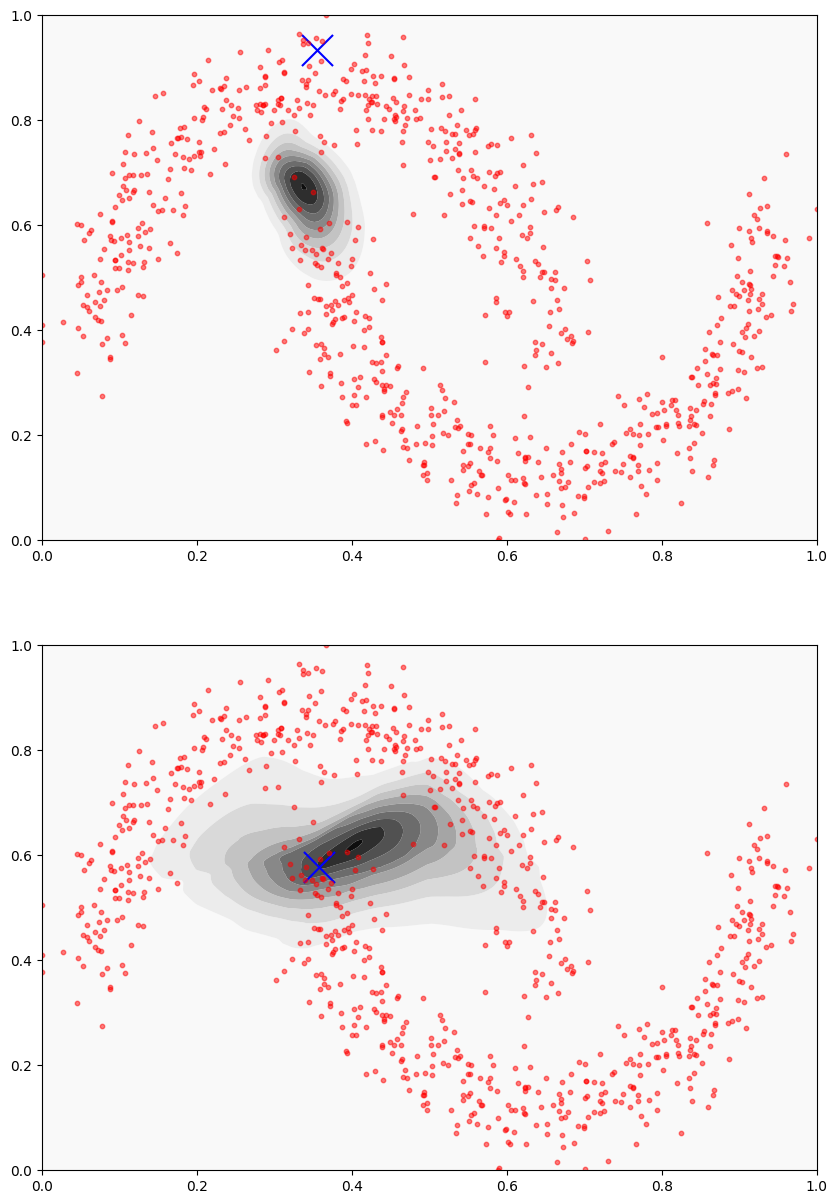

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

i = 52
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_zero[i]])), temp=1.0
    )
points = points.squeeze().numpy()
plot_generative_model_distribution(
    ax[0], cf, None, torch.Tensor([class_zero[i]]), contourf=True
)
ax[0].scatter(class_zero[i, 0], class_zero[i, 1], c="blue", marker="x", s=500)
ax[0].scatter(
    pair_dataset_train.class_one[:, 0],
    pair_dataset_train.class_one[:, 1],
    c="red",
    s=10,
    alpha=0.5,
)
ax[0].scatter(
    pair_dataset_train.class_zero[:, 0],
    pair_dataset_train.class_zero[:, 1],
    c="red",
    s=10,
    alpha=0.5,
)

i = 55
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_one[i]])), temp=1.0
    )
points = points.squeeze().numpy()
plot_generative_model_distribution(
    ax[1], cf, None, torch.Tensor([class_one[i]]), contourf=True
)
ax[1].scatter(class_one[i, 0], class_one[i, 1], c="blue", marker="x", s=500)
ax[1].scatter(
    pair_dataset_train.class_one[:, 0],
    pair_dataset_train.class_one[:, 1],
    c="red",
    s=10,
    alpha=0.5,
)
ax[1].scatter(
    pair_dataset_train.class_zero[:, 0],
    pair_dataset_train.class_zero[:, 1],
    c="red",
    s=10,
    alpha=0.5,
)

AttributeError: 'int' object has no attribute 'repeat'

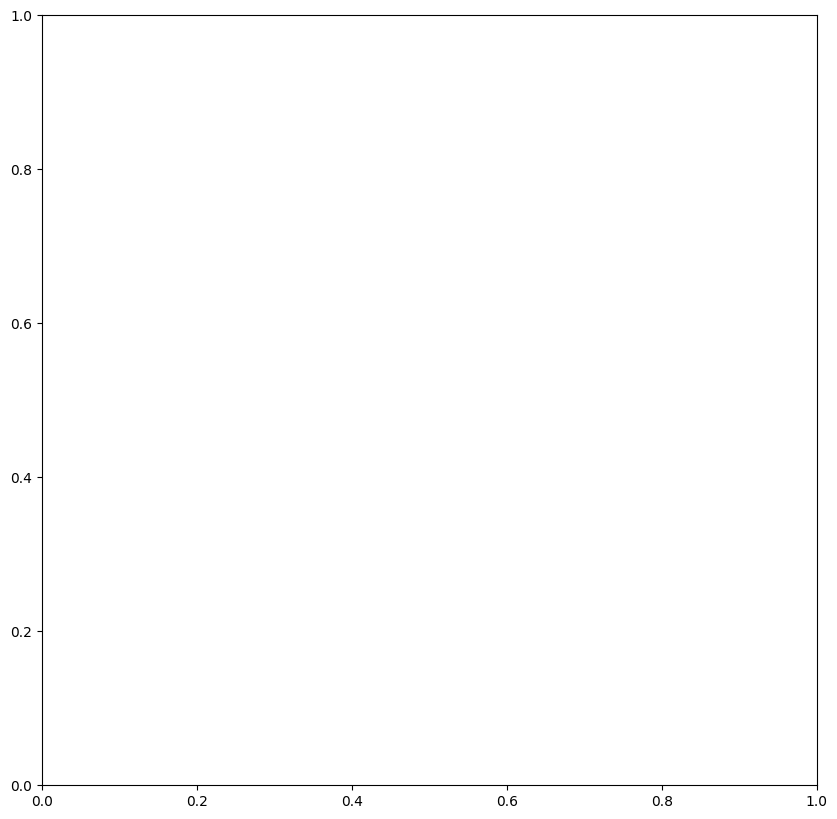

In [17]:
i = 1
with torch.no_grad():
    points, log_prob = cf.sample_and_log_prob(
        1000, context=torch.from_numpy(np.array([class_zero[i]]))
    )

points = points.squeeze().numpy()
# plot points with colorized log prob
fig, ax = plt.subplots(figsize=(10, 10))
plot_generative_model_distribution(ax, flow, 1.2, 2)
ax.scatter(class_zero[i, 0], class_zero[i, 1], c="blue", s=500)
ax.scatter(points[:, 0], points[:, 1], c=log_prob, cmap=cm.coolwarm)

In [ ]:
cfs = []
with torch.no_grad():
    for x in dataset.X_test:
        points, log_prob = cf.sample_and_log_prob(
            100, context=torch.from_numpy(np.array([x]))
        )
        cfs.append(points)

# replace dims to 1,0,2
cfs = torch.stack(cfs).squeeze().permute(1, 0, 2).numpy()

In [ ]:
for i in cfs:
    print(i.shape)
    break

(205, 2)


In [ ]:
from tqdm import tqdm

cfs = []
with torch.no_grad():
    for x in dataset.X_test:
        points, log_prob = cf.sample_and_log_prob(
            100, context=torch.from_numpy(np.array([x]))
        )
        cfs.append(points)
cfs = torch.stack(cfs).squeeze().permute(1, 0, 2).numpy()

all_metrics = []
for i in tqdm(range(cfs.shape[0])):
    metrics = CFMetrics(
        X_cf=cfs[i],
        y_target=np.abs(dataset.y_test - 1),
        X_train=dataset.X_train,
        y_train=dataset.y_train,
        X_test=dataset.X_test,
        y_test=dataset.y_test,
        gen_model=flow,
        disc_model=disc_model,
        continuous_features=dataset.numerical_features,
        categorical_features=dataset.categorical_features,
        prob_plausibility_threshold=1.2,
    )

    all_metrics.append(metrics.calc_all_metrics())

# Calculate mean and standard deviation for each metric
mean_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
std_metrics = {key: np.std([m[key] for m in all_metrics]) for key in all_metrics[0]}

# Print the results
for key in mean_metrics:
    print(f"{key}: {mean_metrics[key]:.4f} ± {std_metrics[key]:.4f}")

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]

coverage: 1.0000 ± 0.0000
validity: 0.7306 ± 0.0189
actionability: 0.0000 ± 0.0000
sparsity: 1.0000 ± 0.0000
proximity_categorical_hamming: nan ± nan
proximity_categorical_jaccard: 0.3487 ± 0.0057
proximity_continuous_manhattan: 0.5388 ± 0.0096
proximity_continuous_euclidean: 0.3487 ± 0.0057
proximity_continuous_mad: 4.5146 ± 0.0797
proximity_l2_jaccard: 0.3487 ± 0.0057
proximity_mad_hamming: nan ± nan
prob_plausibility: 0.7499 ± 0.0207
log_density_cf: 1.5886 ± 0.0439
log_density_test: -0.0546 ± 0.0000
lof_scores_cf: 1.0443 ± 0.0039
lof_scores_test: 1.0630 ± 0.0000
isolation_forest_scores_cf: 0.0503 ± 0.0017
isolation_forest_scores_test: 0.0297 ± 0.0000
